<a href="https://colab.research.google.com/github/ilayyd/HomeWork/blob/main/TrafficAcciedentsProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

In [3]:
warnings.simplefilter(action='ignore', category=FutureWarning)
sns.set_theme()

columns = [
    'Date',
    'Time',
    'Year',
    'Day_of_Week'
    ]

DATAFILES = [
    '/content/accidents_2005_to_2007.csv',
    '/content/accidents_2009_to_2011.csv',
    '/content/accidents_2012_to_2014.csv'
    ]

df_accidents = pd.concat([pd.read_csv(f, low_memory=False) for f in DATAFILES])[columns].dropna()
df_accidents.Date = pd.to_datetime( df_accidents.Date, format='%d/%m/%Y')
DAY_NAME = dict( zip(range(1,8),['Sun','Mon','Tue','Wed','Thu','Fri','Sat']))

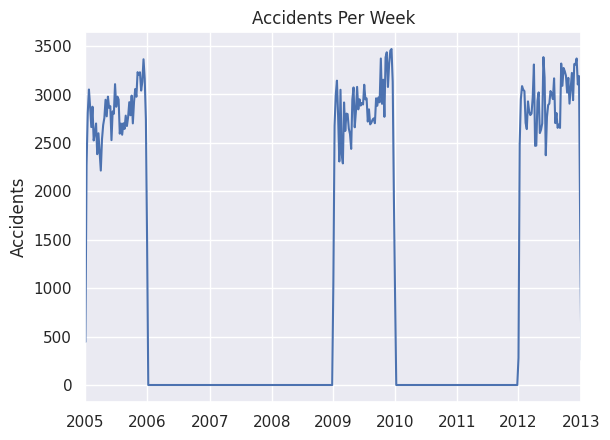

In [4]:
_ = pd.DataFrame(
    index= df_accidents.Date,
    data={'accidents' : 1}
).resample( rule='1W').sum().reset_index()
ax = _.plot(x='Date', y='accidents', legend=False)
ax.set_xlabel(None)
ax.set_ylabel("Accidents")
ax.set_title("Accidents Per Week");

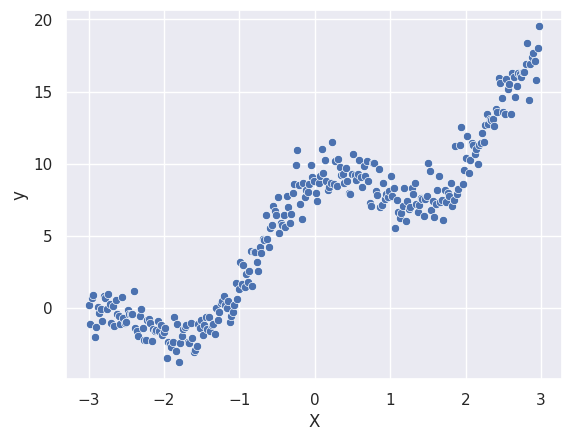

In [5]:
rng = np.random.default_rng(42)
model = lambda a,b: lambda x : a*x + b + a*np.cos(2*x) + rng.normal()

f = model(3,6)
XMIN, XMAX = (-3,3)
pts = np.linspace(XMIN, XMAX, 301,endpoint=False)
df_sample = pd.DataFrame({
    'X' : pts,
    'y' : [f(x) for x in pts]
    })

sns.scatterplot(data=df_sample, x='X', y='y');

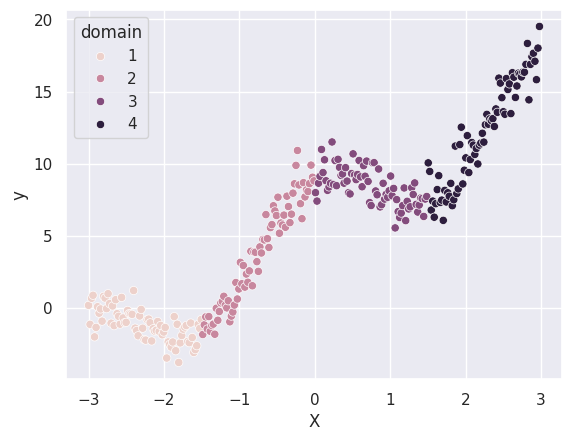

In [6]:
to_domain = lambda x : np.digitize( x, np.linspace(XMIN, XMAX, 5))
df_sample['domain'] = to_domain( df_sample.X )
sns.scatterplot( data=df_sample, x='X', y='y', hue='domain');

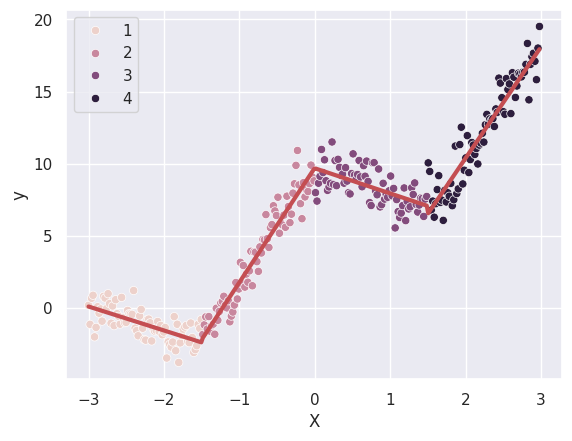

In [7]:
import statsmodels.api as sm

def fit( df ):
    X = sm.add_constant( df[['X']])
    y = df['y']
    result = sm.OLS(y,X).fit()
    return pd.DataFrame({'X':df.X, 'y': result.predict(X)})

_ = pd.concat([
        fit(group) for domain, group in df_sample.groupby('domain')
    ])

fig, ax = plt.subplots()
sns.scatterplot( ax=ax, data=df_sample, x='X', y='y', hue='domain');
sns.lineplot(data=_, x='X', y='y', c='r', lw=3);

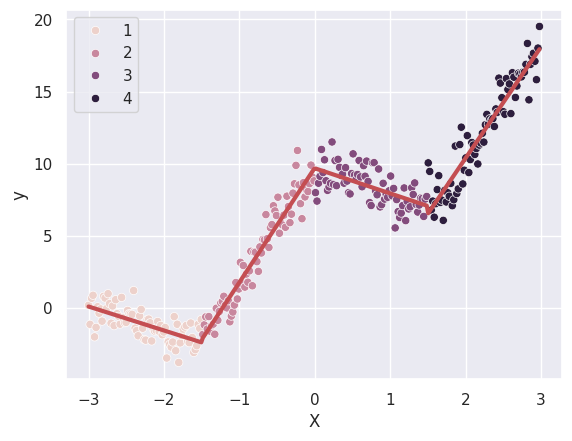

In [8]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression

domains = OneHotEncoder(sparse_output=False).fit_transform( df_sample[['domain']])
encode = lambda X, domains : np.hstack([domains, X*domains])

X = encode( df_sample[['X']].to_numpy(), domains)
y = df_sample['y']
model = LinearRegression().fit(X,y)

fig, ax = plt.subplots()
sns.scatterplot( ax=ax, data=df_sample, x='X', y='y', hue='domain');
sns.lineplot( ax=ax, x=df_sample.X, y=model.predict(X), c='r', lw=3);

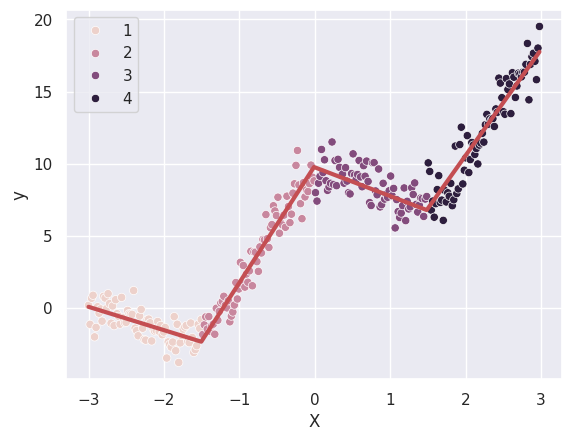

In [9]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import SplineTransformer

n_knots = df_sample.domain.nunique() + 1
spline_fit = SplineTransformer(n_knots=n_knots, knots='uniform', degree=1)
regressor = make_pipeline( spline_fit, LinearRegression())

X = df_sample[['X']]
y = df_sample['y']
model = TransformedTargetRegressor(regressor=regressor ).fit(X,y)

fig, ax = plt.subplots()
sns.scatterplot( ax=ax, data=df_sample, x='X', y='y', hue='domain')
sns.lineplot( ax=ax, x=df_sample.X, y=model.predict(X), c='r', lw=3);

In [14]:
def fit( df, year ):
    _ = df.query(f'Year=={year}')
    if _.empty:
      print(f"Year {year} verisi boş!")
      return pd.DataFrame()
    _ = pd.DataFrame(
            index=_.Date,
            data={'accidents' : 1}
        ).resample( rule='1W').sum().reset_index()
    _['week'] = range(1,len(_)+1)
    _ = _.query('1 < week < 52').copy().reset_index()

    X = sm.add_constant( _.week )
    y = _.accidents
    result = sm.OLS(y,X).fit()

    return pd.DataFrame( {
        'Date' : _.Date,
        'Year' : year,
        'week' : _.week,
        'accidents' : _.accidents,
        'predicted' : np.round( result.predict(X),0)
        })

years = list(range(2005,2015))
years.remove(2008)
df_modelled = pd.concat( [fit(df_accidents, year) for year in years])

Year 2006 verisi boş!
Year 2007 verisi boş!
Year 2010 verisi boş!
Year 2011 verisi boş!
Year 2013 verisi boş!
Year 2014 verisi boş!


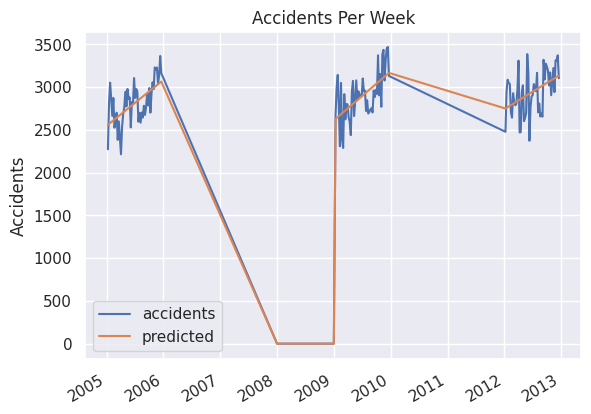

In [15]:
to_date = lambda x : pd.to_datetime(x)
missing_year = pd.DataFrame([
    {'Date':to_date('2008-01-01'), 'Year':2008, 'week':1, 'accidents':0, 'predicted' :0},
    {'Date':to_date('2008-12-31'), 'Year':2008, 'week':1, 'accidents':0, 'predicted' :0},
    ])
fig, ax = plt.subplots( facecolor='white')

_ = pd.concat([df_modelled, missing_year]).sort_values(by='Date').reset_index(drop=True)
_.plot(ax=ax, x='Date', y='accidents')
_.plot(ax=ax, x='Date',y='predicted')
ax.set_xlabel(None)
ax.set_ylabel("Accidents")
ax.set_title("Accidents Per Week");

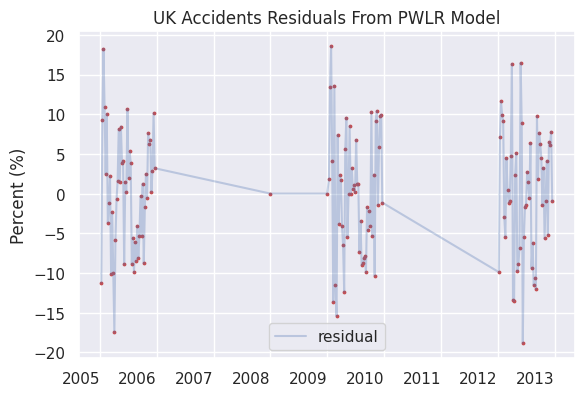

In [16]:
df_residual = pd.DataFrame({
    'Date' : df_modelled.Date,
    'residual' : 100*(df_modelled.accidents - df_modelled.predicted) / df_modelled.predicted
    })
missing_year = pd.DataFrame([
    {'Date':to_date('2008-01-01'), 'residual' : 0},
    {'Date':to_date('2008-12-31'), 'residual' : 0},
    ])
_ = pd.concat([df_residual, missing_year]).sort_values(by='Date').reset_index(drop=True)

fig, ax = plt.subplots()
_.plot(ax=ax, x='Date',y='residual', alpha=0.3)
_.plot.scatter(ax=ax, x='Date',y='residual', c='r', s=3)
ax.set_xlabel(None)
ax.set_ylabel("Percent (%)")
ax.set_title("UK Accidents Residuals From PWLR Model");

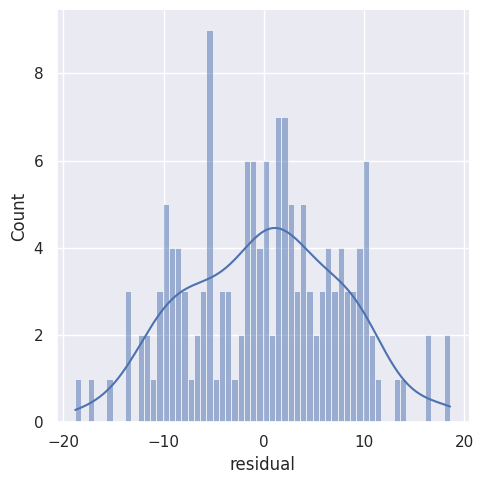

In [17]:
sns.displot( df_residual.residual, kde=True, bins=60);

In [18]:
from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
adf_test( df_residual.residual )

Results of Dickey-Fuller Test:
Test Statistic                  -4.638528
p-value                          0.000110
#Lags Used                      11.000000
Number of Observations Used    138.000000
Critical Value (1%)             -3.478648
Critical Value (5%)             -2.882722
Critical Value (10%)            -2.578065
dtype: float64
